In [1]:
#CRF approach for eCommerce NER
#HMM project
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [25]:
#Install packages for the analysys
!pip install --upgrade pip
!pip install sklearn_crfsuite


Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (18.1)


In [24]:
#Import libraries to complete the task
from itertools import chain
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
#import pycrfsuite

import scipy.stats

from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics


import boto3
from boto.s3.key import Key
import timeit
from io import StringIO
import json
import pandas as pd
import numpy as np
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

print(sklearn.__version__)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
0.19.1


In [4]:
# Load data from S3 package and make parsing

bucket_name = 'masidorov.cs229.ner'
data_file_name = 'all-items-2sets.json'


s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

data_lines = []
obj = bucket.Object(data_file_name)
body = obj.get()['Body'].read().splitlines()
data_lines = body
print(len(data_lines))

INDEX_ID = 0
INDEX_TAGGED = 1
INDEX_TEXT = 2
INDEX_ANNOTATION = 3

# Annotation constants
ANNOTATION_LABEL = 0
ANNOTATION_TEXT = 1
ANNOTATION_POINTS = 2

ANNOTATION_POINTS_START = 1
ANNOTATION_POINTS_STOP = 2

# structure we do support:
# (tagged, text, annotations)
# annotations = [annotation]
# annotation := (label, text, start, stop)
contents = []

id = 0
for line in data_lines:
    dat = json.loads(line)
    content = dat["content"]
    tuple_annotations = []
    annotations = dat["annotation"]
    tagged = False
    if (annotations is not None):
        tagged = True
        for annotation in annotations:
            label = annotation["label"][0]
            points = annotation["points"]
            tuple_annotation = (label)
            
            tuple_points = []
            for point in points:
                text = point["text"]
                start = point["start"]
                stop = point["end"]
                tuple_points.append((text, start, stop))
            tuple_annotations.append((label,text, tuple_points))
    contents.append((id, tagged, content, tuple_annotations))
    id = id + 1
    
    
#DEDUPLICATION
content2tag = {}
for tuple in contents:
    tagged = tuple[INDEX_TAGGED]
    text = tuple[INDEX_TEXT]
    if text not in content2tag.keys():
        content2tag[text] = tagged
    if (not content2tag[text]) and tagged:
        content2tag[text] = tagged
        
visited = {}
dedupe_context = []
for tuple in contents:
    tagged = tuple[INDEX_TAGGED]
    text = tuple[INDEX_TEXT]
    
    if text in visited.keys():
        continue
    
    if (content2tag[text] == tagged):
        visited[text] = True
        dedupe_context.append(tuple)
        
print("Before dedupe=", len(contents), "After dedupe=", len(dedupe_context))
contents = dedupe_context

8163
Before dedupe= 8163 After dedupe= 3914


In [5]:
# Now we create 2 lists for analysis per each record 
# word list: [w1,w2,...]
# tagging: [tag1, tag2,...] we assume that we have 1 tag per word
# Method we iterate via contents, for each line:
# 1) Extract text and extract intervals
# 2) scan in text words and for each word try to find start match in annotation list

# CONSTANTS WE USE
TUPLE_ID = 0
TUPLE_TAGGED_ID = 1
TUPLE_WORD_LIST = 2
TUPLE_TAG_LIST = 3

# Extraction of the tagged entities
def find_tag(start, stop, annotations):
    for annotation in annotations:
        points = annotation[ANNOTATION_POINTS]
        #print("Annot=", points)
        point = points[0]
        astart = point[ANNOTATION_POINTS_START]
        astop = point[ANNOTATION_POINTS_STOP]
        
        if (start == astart):
            return annotation[ANNOTATION_LABEL]
        
    return ""
    

# This function is doing a data processing
def process_tuple(content):
    id = content[INDEX_ID]
    tagged = content[INDEX_TAGGED]
    text = content[INDEX_TEXT]
    
    words = []
    tags = []
    pos_tags = []
    
    annotations = content[INDEX_ANNOTATION]
    start = 0
    stop = 0
    for i in range(len(text) + 1):
        if (i == len(text)) or text[i] == ' ':
            stop = i
            wlen = stop - start
            
            if wlen > 0:
                tag = find_tag(start, stop, annotations)
                word = text[start:stop]
                word_tokens = nltk.word_tokenize(word)
                word_pos_tags = nltk.pos_tag(word_tokens)
                words.append(word)
                tags.append(tag)
                word_pos_tag = word_pos_tags[0][1]
                pos_tags.append(word_pos_tag)

            start = stop + 1
    
    return (id, tagged, words, tags, pos_tags)


# We investigate the structure of ptuple and ann
# price like "under $300"
# price like "$300 after discount"
# "item under discount" item "for $300"
def augment_tuple(ptuple):
    
    return ptuple

pcontents = [process_tuple(content) for content in contents]

# Prepare query corpus in CRF-ready format
query_corpus = [ [x for x in zip(query[2], query[4], query[3])]  for query in pcontents if query[TUPLE_TAGGED_ID] == True]

# Prepare training and test set
ROW_TAGGED = len(query_corpus)
train_set_index= np.random.choice(ROW_TAGGED, size=int(ROW_TAGGED*0.90), replace=False)
dev_set_index = list(set(range(ROW_TAGGED)) - set(train_set_index))
train_set = [query_corpus[i] for i in train_set_index]
dev_set = [query_corpus[i] for i in dev_set_index]


print('Total size of set=', len(query_corpus), 'TrainSet Size=', len(train_set), 'Dev test size=', len(dev_set))

Total size of set= 1753 TrainSet Size= 1577 Dev test size= 176


In [7]:
# Features extraction logic
# Note: code copied from source: https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html 

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]



In [8]:
%%time 
# Features extraction 

X_train = [sent2features(s) for s in train_set]
y_train = [sent2labels(s) for s in train_set]

X_test = [sent2features(s) for s in dev_set]
y_test = [sent2labels(s) for s in dev_set]

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.7 ms


In [9]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 406 ms, sys: 4.18 ms, total: 410 ms
Wall time: 410 ms


In [11]:
labels = list(crf.classes_)
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.5770992094924683

In [16]:

print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

             precision    recall  f1-score   support

   Category      0.577     0.693     0.629       114
      Brand      0.627     0.607     0.617        61
  ModelName      0.596     0.646     0.620        96
                 0.396     0.388     0.392       103
      Price      0.000     0.000     0.000         8
 ScreenSize      0.250     0.100     0.143        10
        RAM      0.000     0.000     0.000         6
    Storage      0.000     0.000     0.000         9

avg / total      0.502     0.538     0.518       407



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

CPU times: user 2.15 s, sys: 82.6 ms, total: 2.23 s
Wall time: 5.98 s


In [13]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)


best params: {'c1': 0.031280655066843, 'c2': 0.18881123246284265}
best CV score: 0.5289451599055116


Dark blue => 0.4713, dark red => 0.5289


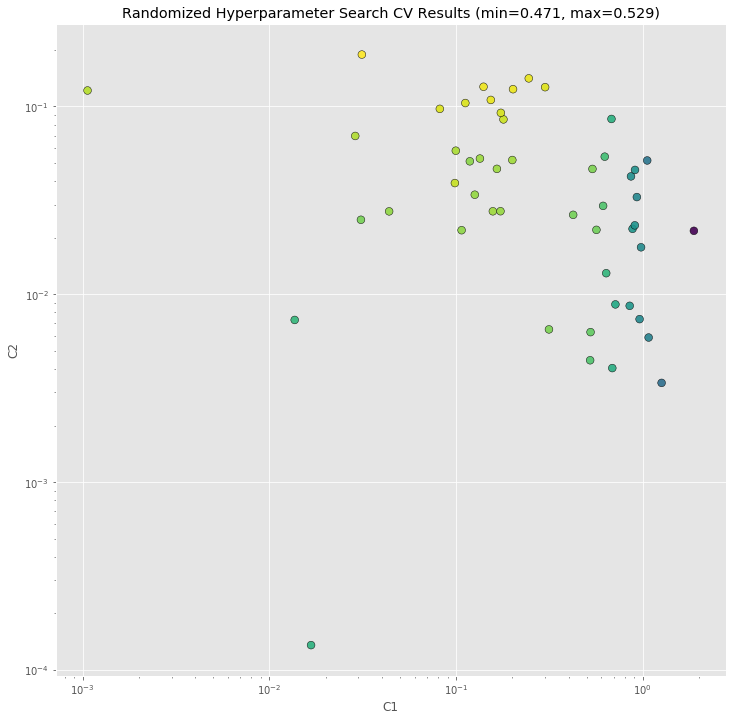

In [14]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [22]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=['Brand', 'Category', 'ModelName'], digits=3
))

             precision    recall  f1-score   support

      Brand      0.629     0.609     0.619        64
   Category      0.667     0.760     0.710       121
  ModelName      0.570     0.718     0.635        85

avg / total      0.627     0.711     0.665       270



In [19]:
y_test[0],y_pred[0]

(['Brand', 'ScreenSize', '', '', '', ''],
 ['Brand', 'ScreenSize', '', '', '', 'Category'])